# LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split,cross_val_score, KFold, cross_val_predict
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn import metrics
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
import xgboost as xgb
from itertools import product


#READING THE DATA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Change to your data directory
#data = pd.read_csv('/content/drive/MyDrive/Master/Courses/Summer Term/Intro to Machine Learning/Project/data.csv')
data = pd.read_csv('drive/MyDrive/UT_AUSTIN/SUMMER_PROGRAMMING/ML/PROYECTO/data.csv')
data.head()

,mora,atraso,vivienda,edad,dias_lab,exp_sf,nivel_ahorro,ingreso,linea_sf,deuda_sf,score,zona,clasif_sbs,nivel_educ
0,0,235,FAMILIAR,30,3748,93.0,5,3500.0,NaN,0.00,214,Lima,4,UNIVERSITARIA
1,0,18,FAMILIAR,32,4598,9.0,12,900.0,1824.67,1933.75,175,La Libertad,1,TECNICA
2,0,0,FAMILIAR,26,5148,8.0,2,2400.0,2797.38,188.29,187,Lima,0,UNIVERSITARIA
3,0,0,FAMILIAR,36,5179,20.0,12,2700.0,NaN,0.00,187,Ancash,0,TECNICA
4,0,0,FAMILIAR,46,3960,NaN,1,3100.0,2000.00,11010.65,189,Lima,0,TECNICA


In [ ]:
#Translate the data
data.columns = ['Default','Delay','Housing','Age','worked_day','FS_exp','Saving','Income','Credit_line','Debt','Score','GeoZone','SBS_score','Education']
data['Housing'] = data['Housing'].replace(['FAMILIAR', 'PROPIA', 'ALQUILADA'],['FamilyHouse', 'OwnHome', 'RentedHousing'])
data['Education'] = data['Education'].replace(['UNIVERSITARIA', 'TECNICA', 'SECUNDARIA', 'SIN EDUCACION'],['College', 'Associate_Degree','High_School', 'Non_Education'])
data.head()

,Default,Delay,Housing,Age,worked_day,FS_exp,Saving,Income,Credit_line,Debt,Score,GeoZone,SBS_score,Education
0,0,235,FamilyHouse,30,3748,93.0,5,3500.0,NaN,0.00,214,Lima,4,College
1,0,18,FamilyHouse,32,4598,9.0,12,900.0,1824.67,1933.75,175,La Libertad,1,Associate_Degree
2,0,0,FamilyHouse,26,5148,8.0,2,2400.0,2797.38,188.29,187,Lima,0,College
3,0,0,FamilyHouse,36,5179,20.0,12,2700.0,NaN,0.00,187,Ancash,0,Associate_Degree
4,0,0,FamilyHouse,46,3960,NaN,1,3100.0,2000.00,11010.65,189,Lima,0,Associate_Degree


#IMPUTATION ANALYSIS

In [ ]:
#Basic Descriptions
resumen = data.describe().T
resumen['fillrate'] = resumen['count']/len(data)
resumen

,count,mean,std,min,25%,50%,75%,max,fillrate
Default,8399.0,0.704251,0.456406,0.0,0.0000,1.000,1.0000,1.00,1.000000
Delay,8399.0,4.463150,14.270840,0.0,0.0000,0.000,2.0000,245.00,1.000000
Age,8399.0,36.399095,9.825764,20.0,29.0000,34.000,42.0000,85.00,1.000000
worked_day,8399.0,5555.888796,2153.244140,2956.0,4174.0000,4904.000,6182.0000,20700.00,1.000000
FS_exp,6569.0,32.401583,32.866232,0.0,7.0000,20.000,51.0000,130.00,0.782117
Saving,8399.0,10.593166,3.374619,0.0,12.0000,12.000,12.0000,12.00,1.000000
Income,8399.0,4350.406997,5367.058953,123.7,1366.6700,2400.000,4900.0000,30000.00,1.000000
Credit_line,7272.0,11987.241038,21322.801655,0.0,1169.3725,4030.120,12086.6275,121543.40,0.865817
Debt,7938.0,6110.724308,11177.989799,0.0,478.3200,2258.755,5755.1500,57094.38,0.945113
Score,8399.0,196.619955,19.544348,134.0,182.0000,197.000,212.0000,266.00,1.000000


In [ ]:
#Cut in segments to check if the missings are similar to any category and if they are near the ones with value=0
def check_where_to_put_missing(data, variable,target):
    data2 = data[[variable,target]]
    data2['cat_'+variable] = np.where(data[variable].isnull(),'0.nan',
                           np.where(data[variable]<=data[variable].quantile(0.2),'1. <='+str(data[variable].quantile(0.2)),
                           np.where(data[variable]<=data[variable].quantile(0.4),'2. <='+str(data[variable].quantile(0.4)),
                           np.where(data[variable]<=data[variable].quantile(0.6),'3. <='+str(data[variable].quantile(0.6)),
                           np.where(data[variable]<=data[variable].quantile(0.8),'4. <='+str(data[variable].quantile(0.8)),'4. <='+str(data[variable].quantile(0.8))
                           )))))
    mean = data2.groupby(['cat_'+variable])[target].mean().reset_index().rename(columns={target:'mean_'+target})
    n    = data2.groupby(['cat_'+variable])[target].count().reset_index().rename(columns={target:'n_'+target})

    resumen = mean.merge(n,on='cat_'+variable,how='left')

    return resumen



In [ ]:
check_where_to_put_missing(data, 'Debt','Default')

<ipython-input-6-1b08ea367b6c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['cat_'+variable] = np.where(data[variable].isnull(),'0.nan',


,cat_Debt,mean_Default,n_Default
0,0.nan,0.613883,461
1,1. <=241.5760000000002,0.642947,1588
2,2. <=1527.6580000000004,0.713926,1587
3,3. <=3301.49,0.757080,1589
4,4. <=7276.422000000001,0.716761,3174


In [ ]:
# Observations with missings are similar to 0. Aditionally, missing values in this variable indicate 0 debt.
data[data['Debt']==0]['Default'].mean()

0.6430379746835443

In [ ]:
check_where_to_put_missing(data, 'FS_exp','Default')

<ipython-input-6-1b08ea367b6c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['cat_'+variable] = np.where(data[variable].isnull(),'0.nan',


,cat_FS_exp,mean_Default,n_Default
0,0.nan,0.798907,1830
1,1. <=3.0,0.790455,1341
2,2. <=14.0,0.775480,1354
3,3. <=29.0,0.712393,1283
4,4. <=63.0,0.551525,2591


In [ ]:
# Observations with missings are similar to 0. Aditionally, missing values in this variable indicate no experience in the financial system.
data[data['FS_exp']==0]['Default'].mean()

0.7941176470588235

In [ ]:
check_where_to_put_missing(data, 'Credit_line','Default')

<ipython-input-6-1b08ea367b6c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['cat_'+variable] = np.where(data[variable].isnull(),'0.nan',


,cat_Credit_line,mean_Default,n_Default
0,0.nan,0.785271,1127
1,1. <=834.574,0.776632,1455
2,2. <=2630.99,0.780069,1455
3,3. <=6113.5,0.720962,1455
4,4. <=15067.98,0.590299,2907


In [ ]:
# Observations with missings are similar to 0. Aditionally, missing values in this variable indicate 0 credit line.
data[data['Credit_line']==0]['Default'].mean()

0.7884872824631861

#DATA CLEANING

In [ ]:
#Imputation
data['Debt_imp'] = data['Debt'].fillna(0)
data['FS_exp_imp']   = data['FS_exp'].fillna(0)
data['Credit_line_imp'] = data['Credit_line'].fillna(0)
data.head()

,Default,Delay,Housing,Age,worked_day,FS_exp,Saving,Income,Credit_line,Debt,Score,GeoZone,SBS_score,Education,Debt_imp,FS_exp_imp,Credit_line_imp
0,0,235,FamilyHouse,30,3748,93.0,5,3500.0,NaN,0.00,214,Lima,4,College,0.00,93.0,0.00
1,0,18,FamilyHouse,32,4598,9.0,12,900.0,1824.67,1933.75,175,La Libertad,1,Associate_Degree,1933.75,9.0,1824.67
2,0,0,FamilyHouse,26,5148,8.0,2,2400.0,2797.38,188.29,187,Lima,0,College,188.29,8.0,2797.38
3,0,0,FamilyHouse,36,5179,20.0,12,2700.0,NaN,0.00,187,Ancash,0,Associate_Degree,0.00,20.0,0.00
4,0,0,FamilyHouse,46,3960,NaN,1,3100.0,2000.00,11010.65,189,Lima,0,Associate_Degree,11010.65,0.0,2000.00


In [ ]:
#feature GeoZone
data['GeoZone_cat'] = np.where(data['GeoZone'].isin(['AmaGeoZones','Madre de Dios','San Martin','Loreto','Ucayali']),'jungle',
                   np.where(data['GeoZone'].isin(['Puno','Ica','Cuzco','Ayacucho','Moquegua','Tacna','Arequipa','Huancavelica']),'south',
                   np.where(data['GeoZone'].isin(['Tumbes','Piura','La Libertad','Cajamarca','Lambayeque']),'north',
                   np.where(data['GeoZone'].isin(['Pasco','Ancash','Callao','Apurimac','Junin','Huanuco']),'center','Lima'))))
data.groupby(['GeoZone_cat'])['Default'].mean()




GeoZone_cat
Lima      0.673961
center    0.760989
jungle    0.925197
north     0.764167
south     0.659404
Name: Default, dtype: float64

In [ ]:
#feature Capital-provinces
data['FLG_LIMA'] = np.where(data['GeoZone'].isin(['Lima']),1,0)
data.groupby(['FLG_LIMA'])['Default'].mean()



FLG_LIMA
0    0.748464
1    0.673896
Name: Default, dtype: float64

In [ ]:
#Transformation of categorical

data['Education_st'] = np.where(data['Education']=='College',4,
                           np.where(data['Education']=='Associate_Degree',3,
                           np.where(data['Education']=='High_School',2,
                           np.where(data['Education']=='SIN Non_Education',1,0))))

for i in ['Housing','GeoZone_cat']:
    tmp  = data.groupby(i)['Default'].mean().reset_index().rename(columns={'Default':i+'_st'})
    data = data.merge(tmp,on=i,how='left')

data.head()

,Default,Delay,Housing,Age,worked_day,FS_exp,Saving,Income,Credit_line,Debt,...,SBS_score,Education,Debt_imp,FS_exp_imp,Credit_line_imp,GeoZone_cat,FLG_LIMA,Education_st,Housing_st,GeoZone_cat_st
0,0,235,FamilyHouse,30,3748,93.0,5,3500.0,NaN,0.00,...,4,College,0.00,93.0,0.00,Lima,1,4,0.721339,0.673961
1,0,18,FamilyHouse,32,4598,9.0,12,900.0,1824.67,1933.75,...,1,Associate_Degree,1933.75,9.0,1824.67,north,0,3,0.721339,0.764167
2,0,0,FamilyHouse,26,5148,8.0,2,2400.0,2797.38,188.29,...,0,College,188.29,8.0,2797.38,Lima,1,4,0.721339,0.673961
3,0,0,FamilyHouse,36,5179,20.0,12,2700.0,NaN,0.00,...,0,Associate_Degree,0.00,20.0,0.00,center,0,3,0.721339,0.760989
4,0,0,FamilyHouse,46,3960,NaN,1,3100.0,2000.00,11010.65,...,0,Associate_Degree,11010.65,0.0,2000.00,Lima,1,3,0.721339,0.673961


In [ ]:
data.columns

Index(['Default', 'Delay', 'Housing', 'Age', 'worked_day', 'FS_exp', 'Saving',
       'Income', 'Credit_line', 'Debt', 'Score', 'GeoZone', 'SBS_score',
       'Education', 'Debt_imp', 'FS_exp_imp', 'Credit_line_imp', 'GeoZone_cat',
       'FLG_LIMA', 'Education_st', 'Housing_st', 'GeoZone_cat_st'],
      dtype='object')

In [ ]:
final_vars = [ 'Default', 'Delay', 'Age', 'worked_day',  'Saving', 'Income',
              'Score', 'SBS_score','Debt_imp', 'FS_exp_imp', 'Credit_line_imp',
              'FLG_LIMA', 'Education_st', 'Housing_st', 'GeoZone_cat_st']

In [ ]:
data.columns

Index(['Default', 'Delay', 'Housing', 'Age', 'worked_day', 'FS_exp', 'Saving',
       'Income', 'Credit_line', 'Debt', 'Score', 'GeoZone', 'SBS_score',
       'Education', 'Debt_imp', 'FS_exp_imp', 'Credit_line_imp', 'GeoZone_cat',
       'FLG_LIMA', 'Education_st', 'Housing_st', 'GeoZone_cat_st'],
      dtype='object')

#REGRESSION

In [ ]:
vars_base = [ 'Delay', 'Age', 'worked_day', 'Saving', 'Income',  'Score',  'SBS_score',
        'Debt_imp', 'FS_exp_imp', 'Credit_line_imp', 'FLG_LIMA', 'Education_st', 'Housing_st', 'GeoZone_cat_st']

In [ ]:
#LOGISTIC REG
# Split data into training and test sets
X_train_logit, X_val_logit, y_train_logit, y_val_logit = train_test_split(data[vars_base], data['Default'], test_size=0.3, random_state=1)
X_val_logit, X_test_logit, y_val_logit, y_test_logit = train_test_split(X_val_logit, y_val_logit, test_size=0.5, random_state=1)

# Standardize data
scaler = StandardScaler()

X_train_logit = scaler.fit_transform(X_train_logit)
X_val_logit = scaler.transform(X_val_logit)
X_test_logit = scaler.transform(X_test_logit)

# Set up a list of different C (lasso or lambda) values to try
C_list = [1, 0.8, 0.5, 0.1, 0.05, 0.03, 0.02, 0.01, 0.005, 0.003, 0.0025, 0.002]
best_score = 0
best_C = None

#TUNING: For each C value...
for C in C_list:
    # Create model
    logit_lasso = LogisticRegression(penalty='l1', solver='liblinear', C=C)
    logit_lasso.fit(X_train_logit, y_train_logit)

    # Validate the model
    y_val_pred = logit_lasso.predict(X_val_logit)
    score = precision_score(y_val_logit, y_val_pred)

    # Print and save the score
    print(f'Precision for C={C}:', score)
    if score > best_score:
        best_score = score
        best_C = C

# Train a model with the best C-Value
logit_lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
logit_lasso.fit(X_train_logit, y_train_logit)

# Evaluate the model on the test set
y_test_pred = logit_lasso.predict(X_test_logit)
print('Best Model Performance:')
print(classification_report(y_test_logit, y_test_pred))

# Print the coefficients of the best model
print('Coefficients:', logit_lasso.coef_)

print("-----------------------------------------------------")

# For interpretation and significance, we fit the model without regularization (Lasso) using statsmodels
X_train_logit_sm = sm.add_constant(X_train_logit)  # Adding constant for the intercept term
logit_model = sm.Logit(y_train_logit, X_train_logit_sm)
result = logit_model.fit()

# Print out the statistics
print(result.summary())

# Get the confusion matrix for the best model
conf_mat = confusion_matrix(y_test_logit, y_test_pred)
print('Confusion Matrix:\n', conf_mat)

# Print AIC (Akaike's Information Criterion)
print('AIC:', result.aic)

Precision for C=1: 0.7541133455210237
Precision for C=0.8: 0.7541133455210237
Precision for C=0.5: 0.7541133455210237
Precision for C=0.1: 0.7540983606557377
Precision for C=0.05: 0.7520361990950226
Precision for C=0.03: 0.7504504504504504
Precision for C=0.02: 0.7495495495495496
Precision for C=0.01: 0.7448522829006267
Precision for C=0.005: 0.7367044463818657
Precision for C=0.003: 0.7331628303495311
Precision for C=0.0025: 0.7277268942547876
Precision for C=0.002: 0.7163461538461539
Best Model Performance:
              precision    recall  f1-score   support

           0       0.57      0.26      0.35       353
           1       0.76      0.92      0.84       907

    accuracy                           0.74      1260
   macro avg       0.67      0.59      0.59      1260
weighted avg       0.71      0.74      0.70      1260

Coefficients: [[ 0.2310485   0.09983851 -0.08819827 -0.25109181 -0.05270422 -0.28801896
   0.24439449  0.20412274 -0.41699383 -0.17274666  0.08988354 -0.11634

Feature engineering

In [ ]:
data['House_FAM'] = np.where(data['Housing']=='FamilyHouse',1,0)
data['House_OWN'] = np.where(data['Housing']=='OwnHome',1,0)

data['zone_lim'] = np.where(data['GeoZone_cat']=='Lima',1,0)
data['zone_north'] = np.where(data['GeoZone_cat']=='north',1,0)
data['zone_center'] = np.where(data['GeoZone_cat']=='center',1,0)
data['zone_south'] = np.where(data['GeoZone_cat']=='south',1,0)



In [ ]:
final_vars = ['Delay', 'Age', 'worked_day',  'Saving', 'Income',
              'Score', 'SBS_score','Debt_imp', 'FS_exp_imp', 'Credit_line_imp']

for i in range(len(final_vars)):
    data[final_vars[i]+'_p2'] = data[final_vars[i]]**2
    data[final_vars[i]+'_p3'] = data[final_vars[i]]**3
    for j in range(i+1,len(final_vars)):
        data[final_vars[i]+'__'+final_vars[j]] = data[final_vars[i]]*data[final_vars[j]]

data.columns

Index(['Default', 'Delay', 'Housing', 'Age', 'worked_day', 'FS_exp', 'Saving',
       'Income', 'Credit_line', 'Debt', 'Score', 'GeoZone', 'SBS_score',
       'Education', 'Debt_imp', 'FS_exp_imp', 'Credit_line_imp', 'GeoZone_cat',
       'FLG_LIMA', 'Education_st', 'Housing_st', 'GeoZone_cat_st', 'House_FAM',
       'House_OWN', 'zone_lim', 'zone_north', 'zone_center', 'zone_south',
       'Delay_p2', 'Delay_p3', 'Delay__Age', 'Delay__worked_day',
       'Delay__Saving', 'Delay__Income', 'Delay__Score', 'Delay__SBS_score',
       'Delay__Debt_imp', 'Delay__FS_exp_imp', 'Delay__Credit_line_imp',
       'Age_p2', 'Age_p3', 'Age__worked_day', 'Age__Saving', 'Age__Income',
       'Age__Score', 'Age__SBS_score', 'Age__Debt_imp', 'Age__FS_exp_imp',
       'Age__Credit_line_imp', 'worked_day_p2', 'worked_day_p3',
       'worked_day__Saving', 'worked_day__Income', 'worked_day__Score',
       'worked_day__SBS_score', 'worked_day__Debt_imp',
       'worked_day__FS_exp_imp', 'worked_day__Credit_

In [ ]:
target = 'Default'

final_vars = ['Delay', 'Age', 'worked_day', 'Saving',
       'Income', 'Score', 'SBS_score', 'Debt_imp',
       'FS_exp_imp', 'Credit_line_imp', 'Education_st','House_FAM',
       'House_OWN', 'zone_lim', 'zone_north', 'zone_center', 'zone_south',
       'Delay_p2', 'Delay_p3', 'Delay__Age', 'Delay__worked_day',
       'Delay__Saving', 'Delay__Income', 'Delay__Score', 'Delay__SBS_score',
       'Delay__Debt_imp', 'Delay__FS_exp_imp', 'Delay__Credit_line_imp',
       'Age_p2', 'Age_p3', 'Age__worked_day', 'Age__Saving', 'Age__Income',
       'Age__Score', 'Age__SBS_score', 'Age__Debt_imp', 'Age__FS_exp_imp',
       'Age__Credit_line_imp', 'worked_day_p2', 'worked_day_p3',
       'worked_day__Saving', 'worked_day__Income', 'worked_day__Score',
       'worked_day__SBS_score', 'worked_day__Debt_imp',
       'worked_day__FS_exp_imp', 'worked_day__Credit_line_imp', 'Saving_p2',
       'Saving_p3', 'Saving__Income', 'Saving__Score', 'Saving__SBS_score',
       'Saving__Debt_imp', 'Saving__FS_exp_imp', 'Saving__Credit_line_imp',
       'Income_p2', 'Income_p3', 'Income__Score', 'Income__SBS_score',
       'Income__Debt_imp', 'Income__FS_exp_imp', 'Income__Credit_line_imp',
       'Score_p2', 'Score_p3', 'Score__SBS_score', 'Score__Debt_imp',
       'Score__FS_exp_imp', 'Score__Credit_line_imp', 'SBS_score_p2',
       'SBS_score_p3', 'SBS_score__Debt_imp', 'SBS_score__FS_exp_imp',
       'SBS_score__Credit_line_imp', 'Debt_imp_p2', 'Debt_imp_p3',
       'Debt_imp__FS_exp_imp', 'Debt_imp__Credit_line_imp', 'FS_exp_imp_p2',
       'FS_exp_imp_p3', 'FS_exp_imp__Credit_line_imp', 'Credit_line_imp_p2',
       'Credit_line_imp_p3']

Balance

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(data[final_vars],data[target],test_size=0.2,random_state=123)

sc = StandardScaler()
X_train = sc.fit_transform(X_train[final_vars])
X_test = sc.transform(X_test[final_vars])

X_train = pd.DataFrame(X_train, columns = final_vars)
X_test = pd.DataFrame(X_test, columns = final_vars)

In [ ]:
clf = LogisticRegression(random_state=0,class_weight='balanced',penalty='l2',solver='liblinear' )
sfs = SequentialFeatureSelector(clf, n_features_to_select='auto',cv=5, direction='forward')
sfs.fit(X_train,y_train)
final_vars2 = sfs.get_feature_names_out(input_features=final_vars)
print(final_vars2)

In [ ]:
final_vars2 = ['SBS_score', 'House_FAM', 'House_OWN', 'zone_center', 'Delay_p2', 'Delay_p3',
 'Delay__worked_day', 'Delay__Income', 'Delay__SBS_score', 'Delay__Debt_imp',
 'Delay__FS_exp_imp', 'Delay__Credit_line_imp', 'Age__Saving',
 'Age__Debt_imp', 'worked_day__SBS_score', 'Saving_p3', 'Saving__Income',
 'Saving__Score', 'Saving__Debt_imp', 'Income_p2', 'Income_p3',
 'Income__SBS_score', 'Income__Debt_imp', 'Income__FS_exp_imp',
 'Income__Credit_line_imp', 'Score__SBS_score', 'Score__Debt_imp',
 'SBS_score_p2' ,'SBS_score_p3', 'SBS_score__Debt_imp',
 'SBS_score__FS_exp_imp', 'SBS_score__Credit_line_imp', 'Debt_imp_p2',
 'Debt_imp_p3', 'Debt_imp__FS_exp_imp', 'Debt_imp__Credit_line_imp',
 'FS_exp_imp_p2' ,'FS_exp_imp_p3', 'FS_exp_imp__Credit_line_imp',
 'Credit_line_imp_p2', 'Credit_line_imp_p3']

In [ ]:
clf = LogisticRegression(random_state=0,class_weight='balanced',penalty='l2',solver='liblinear')
clf.fit(X_train[final_vars2],y_train)
y_predict = clf.predict(X_test[final_vars2])
clf.score(X_test[final_vars2],y_test)


0.7083333333333334

In [ ]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.51      0.57      0.54       503
           1       0.81      0.77      0.79      1177

    accuracy                           0.71      1680
   macro avg       0.66      0.67      0.66      1680
weighted avg       0.72      0.71      0.71      1680



0.31957617365768476


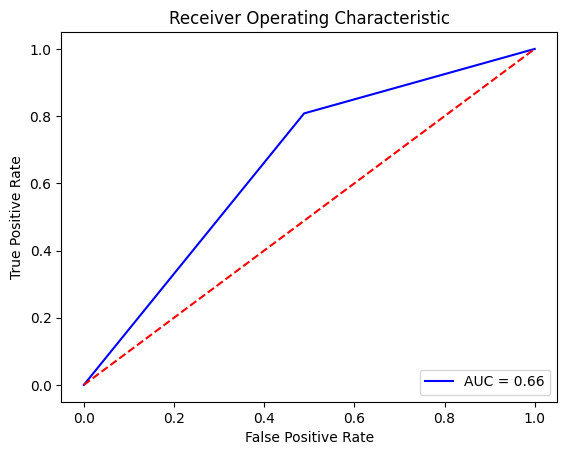

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(y_predict, y_test)
roc_auc = metrics.auc(fpr, tpr)
print(2*roc_auc-1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Unbalanced

In [ ]:
clf = LogisticRegression(random_state=0,penalty='l2',solver='liblinear')
sfs = SequentialFeatureSelector(clf, n_features_to_select='auto',cv=5, direction='forward')
sfs.fit(X_train,y_train)

final_vars2 = sfs.get_feature_names_out(input_features=final_vars)
final_vars2

array(['worked_day_p3', 'worked_day__Score', 'worked_day__SBS_score',
       'worked_day__Debt_imp', 'worked_day__FS_exp_imp',
       'worked_day__Credit_line_imp', 'Saving_p2', 'Saving_p3',
       'Saving__Income', 'Saving__Score', 'Saving__SBS_score',
       'Saving__Debt_imp', 'Saving__FS_exp_imp',
       'Saving__Credit_line_imp', 'Income_p2', 'Income_p3',
       'Income__Score', 'Income__SBS_score', 'Income__Debt_imp',
       'Income__FS_exp_imp', 'Income__Credit_line_imp', 'Score_p2',
       'Score_p3', 'Score__SBS_score', 'Score__Debt_imp',
       'Score__FS_exp_imp', 'Score__Credit_line_imp', 'SBS_score_p2',
       'SBS_score_p3', 'SBS_score__Debt_imp', 'SBS_score__FS_exp_imp',
       'SBS_score__Credit_line_imp', 'Debt_imp_p2', 'Debt_imp_p3',
       'Debt_imp__FS_exp_imp', 'Debt_imp__Credit_line_imp',
       'FS_exp_imp_p2', 'FS_exp_imp_p3', 'FS_exp_imp__Credit_line_imp',
       'Credit_line_imp_p2', 'Credit_line_imp_p3'], dtype=object)

In [ ]:
final_vars2=['Saving', 'Income', 'Debt_imp', 'FS_exp_imp', 'Education_st',
       'zone_center', 'zone_south', 'Delay_p3', 'Delay__Income',
       'Delay__SBS_score', 'Delay__Debt_imp', 'Delay__FS_exp_imp',
       'Age__worked_day', 'Age__SBS_score', 'Age__Debt_imp',
       'Age__Credit_line_imp', 'worked_day_p3', 'worked_day__Saving',
       'worked_day__SBS_score', 'worked_day__Debt_imp', 'Saving_p2',
       'Saving_p3', 'Saving__Income', 'Saving__Score',
       'Saving__SBS_score', 'Saving__Debt_imp', 'Saving__FS_exp_imp',
       'Income_p3', 'Income__Score', 'Income__Debt_imp',
       'Income__Credit_line_imp', 'Score_p3', 'Score__Debt_imp',
       'Score__FS_exp_imp', 'SBS_score_p2', 'SBS_score_p3',
       'SBS_score__Debt_imp', 'SBS_score__FS_exp_imp',
       'Debt_imp__FS_exp_imp', 'FS_exp_imp_p2', 'FS_exp_imp_p3']
print(len(final_vars2))

clf = LogisticRegression(random_state=0,solver='liblinear')
clf.fit(X_train[final_vars2],y_train)
y_predict = clf.predict(X_test[final_vars2])
clf.score(X_test[final_vars2],y_test)



41


0.7440476190476191

In [ ]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.66      0.29      0.41       503
           1       0.76      0.94      0.84      1177

    accuracy                           0.74      1680
   macro avg       0.71      0.62      0.62      1680
weighted avg       0.73      0.74      0.71      1680



In [ ]:
#review p-values
regr_model = sm.Logit(list(y_train),X_train[final_vars2])
regr_results = regr_model.fit()
print(regr_results.summary())

Optimization terminated successfully.
         Current function value: 0.628787
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6719
Model:                          Logit   Df Residuals:                     6678
Method:                           MLE   Df Model:                           40
Date:                Mon, 24 Jul 2023   Pseudo R-squ.:                -0.03688
Time:                        03:45:56   Log-Likelihood:                -4224.8
converged:                       True   LL-Null:                       -4074.6
Covariance Type:            nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Saving                      0.1449      0.455      0.318      0.750      -0.747   

In [ ]:
significants = ['Income',
'Education_st',
'zone_south',
'Delay__Income',
'Age__SBS_score',
'Age__Credit_line_imp',
'worked_day__Debt_imp',
'Income__Debt_imp',
'Score__FS_exp_imp',
'SBS_score__FS_exp_imp',
'Debt_imp__FS_exp_imp']
len(significants)

11

In [ ]:
#BEST MODEL
clf = LogisticRegression(random_state=0,penalty='l2',solver='liblinear')
clf.fit(X_train[significants],y_train)
y_predict = clf.predict(X_test[significants])
clf.score(X_test[significants],y_test)


0.7238095238095238

In [ ]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.60      0.23      0.34       503
           1       0.74      0.93      0.83      1177

    accuracy                           0.72      1680
   macro avg       0.67      0.58      0.58      1680
weighted avg       0.70      0.72      0.68      1680



0.3400673400673402


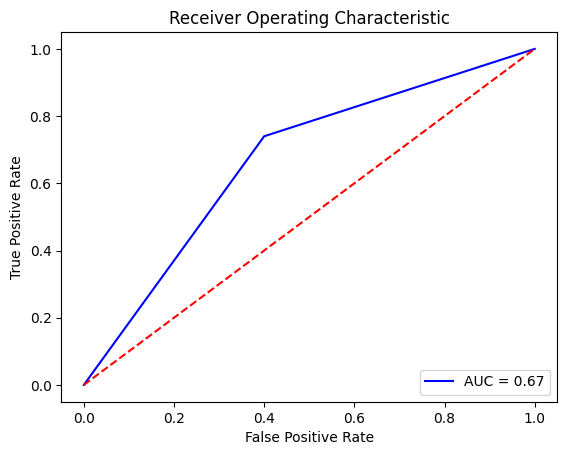

In [ ]:
#ROC-AUC
fpr, tpr, threshold = metrics.roc_curve(y_predict, y_test)
roc_auc = metrics.auc(fpr, tpr)
print(2*roc_auc-1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
regr_model = sm.Logit(list(y_train),X_train[significants])
regr_results = regr_model.fit()
print(regr_results.summary())

Optimization terminated successfully.
         Current function value: 0.642768
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6719
Model:                          Logit   Df Residuals:                     6708
Method:                           MLE   Df Model:                           10
Date:                Mon, 24 Jul 2023   Pseudo R-squ.:                -0.05993
Time:                        03:46:25   Log-Likelihood:                -4318.8
converged:                       True   LL-Null:                       -4074.6
Covariance Type:            nonrobust   LLR p-value:                     1.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Income                   -0.2544      0.041     -6.144      0.000      -0.335      -0.

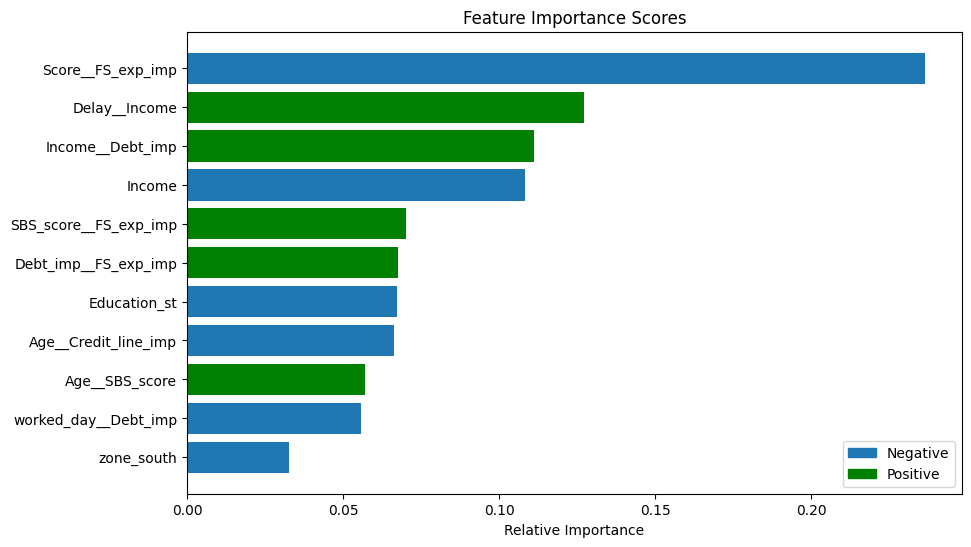

In [ ]:
weights = regr_results.params.reset_index().rename(columns={'index':'vars',0:'coef'})
weights['f_import'] =  np.abs(weights['coef'])/sum( np.abs(weights['coef']))
weights = weights.sort_values(by='f_import')
colors = np.where(weights['coef']<0,'tab:blue','g')
labels = ['Negative','Positive']
handles = [mpatches.Patch(color=i) for i in ['tab:blue','g']]

plt.figure(figsize=(10,6))
plt.title('Feature Importance Scores')
plt.barh(weights['vars'],weights['f_import'],color=colors,align='center')
plt.xlabel('Relative Importance')
plt.legend(handles, labels)
plt.show()



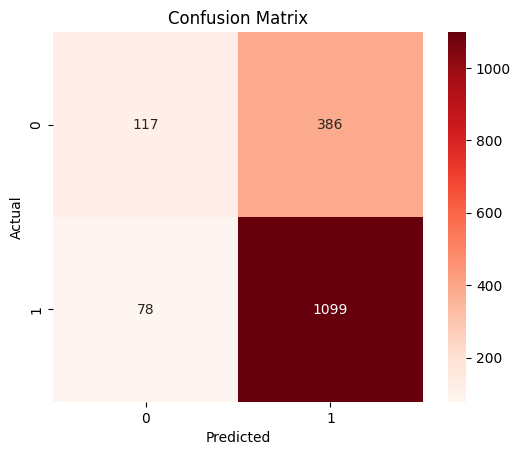

In [ ]:
# A confusion matrix is created to visualize the performance of the model.
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True, fmt=".0f", square=True, cmap='Reds')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()



# Random Forest

In [ ]:
#TUNNING

#Here we tried running different forests with a different combinations of number of trees and depth to identify the best parameters.

data2 = data.drop(['Housing','Education','GeoZone_cat','GeoZone','Debt','FS_exp','Credit_line'], axis=1)

#Set up some parameters

n_trees = list(range(500,5500,500))
tree_depth = list(range(6,15,1))
results = []

#iterate over a few options to find the best answer based on the training and test data over different parameters.

for n in n_trees:
    for depths in tree_depth:
        #First split in train, validation and test
        X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(data2.drop('Default', axis=1), data2['Default'], test_size=0.5, random_state=1)
        X_val_rf, X_test_rf, y_val_rf, y_test_rf = train_test_split(X_val_rf, y_val_rf, test_size=0.5, random_state=42)

        #Create the forest

        rf = RandomForestClassifier(n_estimators=n, max_depth = depths,random_state = 42)

        #Fit the data

        rf.fit(X_train_rf, y_train_rf)

        #Make the predictions on validation and test set

        predictions_val_rf = rf.predict(X_val_rf)
        predictions_test_rf = rf.predict(X_test_rf)

        #Get accuracy of the model

        accuracy_val_rf = accuracy_score(y_val_rf, predictions_val_rf)
        accuracy_test_rf = accuracy_score(y_test_rf, predictions_test_rf)

        #Store results

        result = {'n_trees':n, 'tree_depth':depths,'Accuracy Val':accuracy_val_rf, 'Accuracy Test':accuracy_test_rf}

        results.append(result)



Accuracy: 85.30%


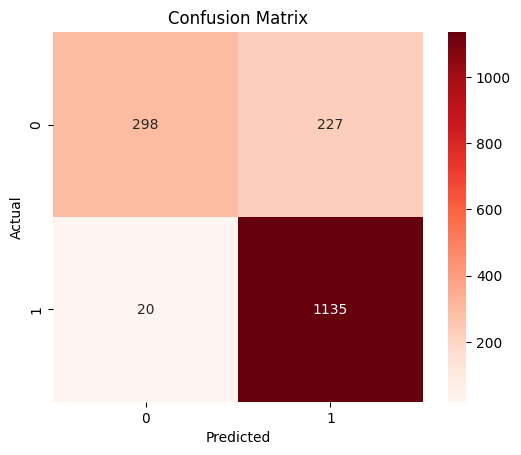

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.57      0.71       525
           1       0.83      0.98      0.90      1155

    accuracy                           0.85      1680
   macro avg       0.89      0.78      0.80      1680
weighted avg       0.87      0.85      0.84      1680



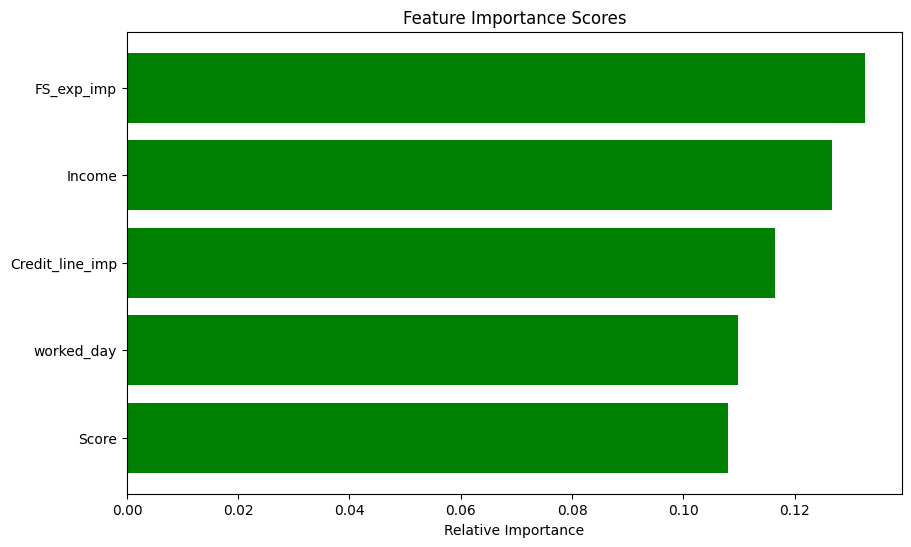

0.7704402515723272


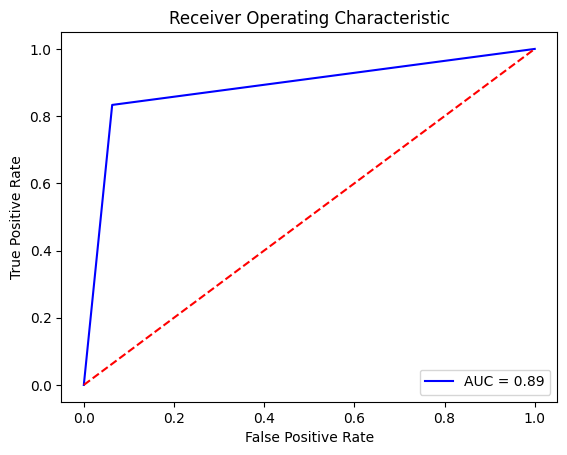

In [ ]:
 #BEST MODEL

# Data Splits
# The data is split into features (X) and target (y).
X = data[final_vars].drop('Default', axis=1)
y = data['Default']
# The data is split into training/test sets (80% train, 20% test).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# The Random Forest Classifier is initialized with 100 trees and fit into the training data.
rf = RandomForestClassifier(n_estimators=3000, max_depth=12, random_state=42)
rf.fit(X_train, y_train)


# The model is tested to see how well it learned from the training data.
y_pred_rf = rf.predict(X_test)


# The accuracy of the model is calculated; simply a proportion of predictions that the model is right.
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy: {:.2f}%".format(accuracy * 100))


# A confusion matrix is created to visualize the performance of the model.
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt=".0f", square=True, cmap='Reds')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


# A classification report is also provided as a summary of the model's performance.
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


# Now, the model provides a feature importance plot to show the scores of each feature within the dataset.
importances = rf.feature_importances_
indices = np.argsort(importances)[-5:]


plt.figure(figsize=(10,6))
plt.title('Feature Importance Scores')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#Finally, we are including a ROC graph to see how the true positives and false positives are behaving.

fpr, tpr, threshold = metrics.roc_curve(y_pred_rf, y_test)
roc_auc = metrics.auc(fpr, tpr)
print(2*roc_auc-1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Gradient Boosting Classifier

In [ ]:
#TUNNING

#Same as for random forest, we tried different models with different values of lambda to check the best parameters.

lambda_list = list(np.arange(0.1, 1.1, 0.1))
boost_result = []

for lambdas in lambda_list:
    X_train_boost, X_val_boost, y_train_boost, y_val_boost = train_test_split(data2.drop('Default', axis=1), data2['Default'], test_size=0.5, random_state=1)
    X_val_boost, X_test_boost, y_val_boost, y_test_boost = train_test_split(X_val_rf, y_val_rf, test_size=0.5, random_state=42)

    boosting_model = GradientBoostingClassifier(n_estimators=3000, learning_rate=lambdas, max_depth=12, random_state = 42)

    # Fit the model on the training data
    boosting_model.fit(X_train_boost, y_train_boost)

    # Make predictions on the test data
    y_pred_boost_val = boosting_model.predict(X_val_boost)
    y_pred_boost_test = boosting_model.predict(X_test_boost)

    accuracy_val_boost = accuracy_score(y_val_boost, y_pred_boost_val)
    accuracy_test_boost = accuracy_score(y_test_boost,y_pred_boost_test)

    result = {'Lambda':lambdas, 'Accuracy Val':accuracy_val_boost, 'Accuracy Test':accuracy_test_boost}

    boost_result.append(result)




Lambda           0.200000
Accuracy Val     0.835238
Accuracy Test    0.866667
Name: 1, dtype: float64


Accuracy: 88.81%


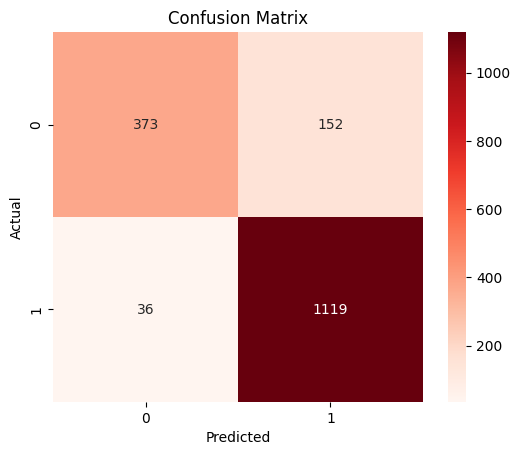

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.71      0.80       525
           1       0.88      0.97      0.92      1155

    accuracy                           0.89      1680
   macro avg       0.90      0.84      0.86      1680
weighted avg       0.89      0.89      0.88      1680



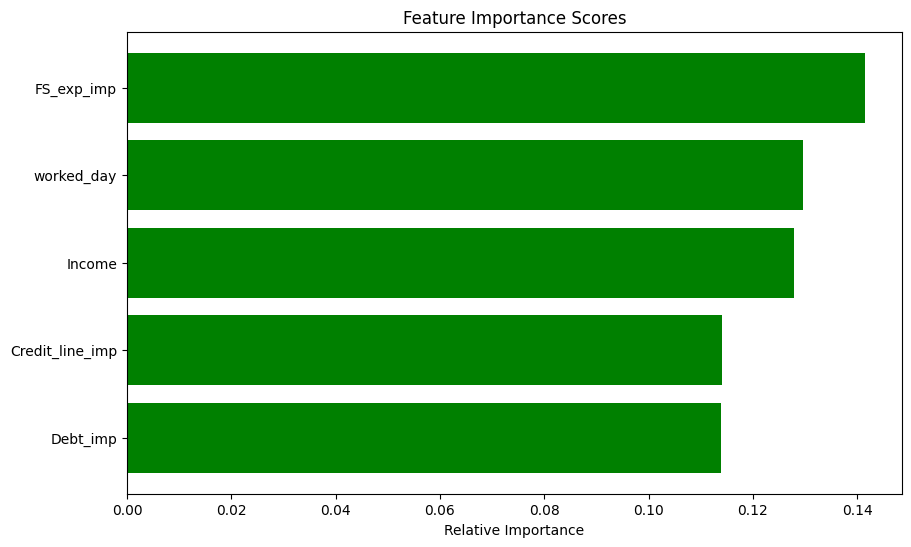

0.7923895667697114


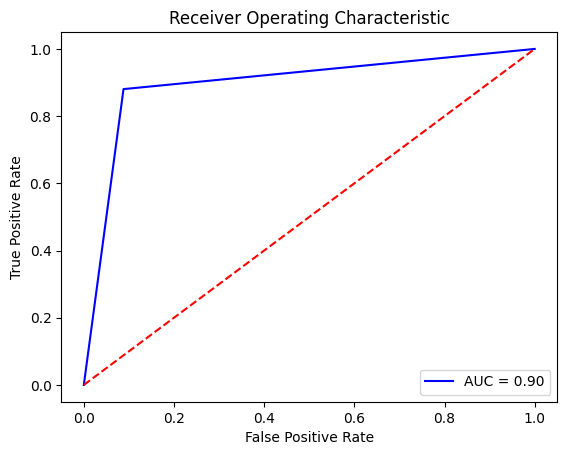

In [ ]:
#BEST MODEL
# Data Splits
# The data is split into features (X) and target (y).
X = data[final_vars].drop('Default', axis=1)
y = data['Default']
# The data is split into training/test sets (80% train, 20% test).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# TThe Gradient Boost Classifier runs using the best inputs from Random Forest
gbc = GradientBoostingClassifier(n_estimators=3000, max_depth=12, random_state=42, learning_rate=0.1)
gbc.fit(X_train, y_train)


# The model is tested to see how well it learned from the training data.
y_pred_gbc = gbc.predict(X_test)


# The accuracy of the model is calculated; simply a proportion of predictions that the model is right.
accuracy = accuracy_score(y_test, y_pred_gbc)
print("Accuracy: {:.2f}%".format(accuracy * 100))


# A confusion matrix is created to visualize the performance of the model.
cm = confusion_matrix(y_test, y_pred_gbc)
sns.heatmap(cm, annot=True, fmt=".0f", square=True, cmap='Reds')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


# A classification report is also provided as a summary of the model's performance.
print("Classification Report:\n", classification_report(y_test, y_pred_gbc))


# Then, the model provides a feature importance plot to show the scores of each feature within the dataset.
importances = gbc.feature_importances_
indices = np.argsort(importances)[-5:]


plt.figure(figsize=(10,6))
plt.title('Feature Importance Scores')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#Lastly, we are including a ROC graph to see how the true positives and false positives are behaving.

fpr, tpr, threshold = metrics.roc_curve(y_pred_gbc, y_test)
roc_auc = metrics.auc(fpr, tpr)
print(2*roc_auc-1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# K-Nearest Neighbors

,Delay,Age,Work_Days,Financial_Sys_Experience,Savings_Level,Income,Credit_Line,Debt,Credit_Score,SBS_Score,Living_Zone_enc,Education_Level_enc
0,16.155362,-0.651296,-0.839662,2.114718,-1.657520,-0.158459,-0.512387,-0.527187,0.889315,3.794770,0.371253,0.740054
1,0.948624,-0.447737,-0.444885,-0.510779,0.416912,-0.642924,-0.422305,-0.350669,-1.106266,0.481988,-0.104474,-0.749453
2,-0.312765,-1.058413,-0.189441,-0.542035,-2.546563,-0.363425,-0.374284,-0.509999,-0.492241,-0.622272,0.371253,0.740054
3,-0.312765,-0.040620,-0.175043,-0.166964,0.416912,-0.307525,-0.512387,-0.527187,-0.492241,-0.622272,-2.720977,-0.749453
4,-0.312765,0.977174,-0.741200,-0.792082,-2.842910,-0.232992,-0.413649,0.477895,-0.389903,-0.622272,0.371253,-0.749453
...,...,...,...,...,...,...,...,...,...,...,...,...
8394,-0.312765,0.671836,1.096602,2.521045,0.416912,1.734683,5.488063,0.233970,1.401002,0.481988,0.371253,0.740054
8395,-0.312765,-0.753075,-1.023581,-0.010684,-3.139257,-0.659135,-0.403775,-0.527187,0.019446,0.481988,0.371253,0.740054
8396,-0.312765,-0.447737,0.587572,-0.198220,0.416912,-0.251625,-0.014404,-0.441958,0.172953,0.481988,0.371253,0.740054
8397,-0.312765,0.162939,-0.777426,-0.573290,0.416912,-0.238725,0.672168,0.746631,1.247496,0.481988,0.133390,0.740054


['uniform', 1, 0.8868932617769829, 0.9174774383177519, 0.9224720719757094]
['uniform', 2, 0.8184327881420903, 0.923225639727169, 0.8097994149656728]
['uniform', 3, 0.7990254706533777, 0.8435675821744126, 0.8777533825019181]
['uniform', 4, 0.7616381293125478, 0.8591623926239043, 0.7915514187098012]
['uniform', 5, 0.7655703211517164, 0.810548680297643, 0.870617617737539]
['uniform', 6, 0.7444967629269955, 0.8226013131653767, 0.8125088779816354]
['uniform', 7, 0.7467590936195588, 0.7921964671514464, 0.8687208442703465]
['uniform', 8, 0.7325913621262459, 0.8028973116547005, 0.8227310929510769]
['uniform', 9, 0.7385445949399437, 0.7825403942223963, 0.8712275352999109]
['uniform', 10, 0.7325905102649288, 0.7925354510726811, 0.8407830387480794]
['uniform', 11, 0.7411632166283331, 0.7810067946197783, 0.8793297633531425]
['uniform', 12, 0.7318770764119601, 0.788023973866762, 0.8475021748584689]
['uniform', 13, 0.7393781412386065, 0.7775682862713867, 0.8827167894708169]
['uniform', 14, 0.7349731

,Weight,n_neighbours,Average_Accuracy,Average Precision,Average Recall
575,distance,77,0.911897,0.907485,0.974396


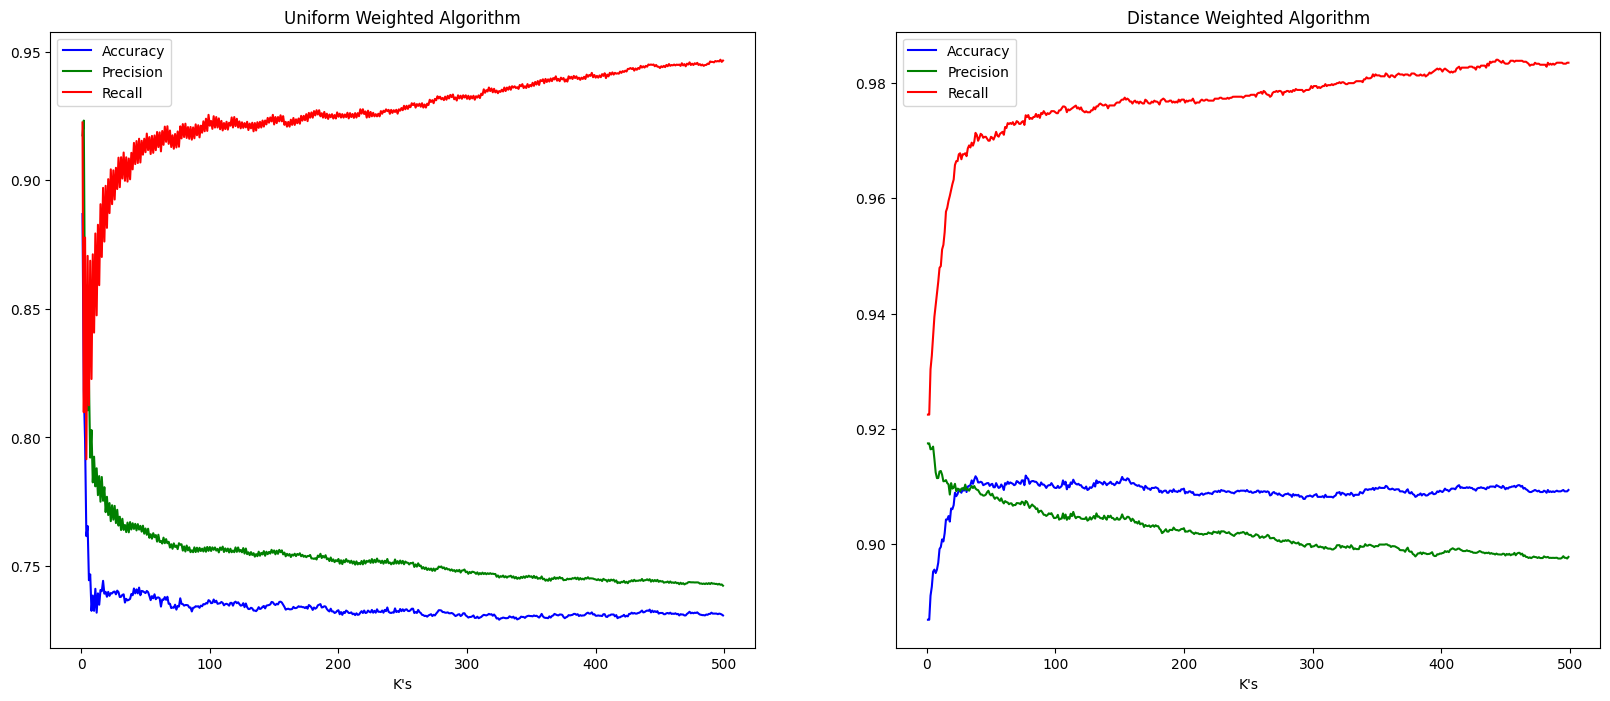

In [ ]:
# Please add file path
df = pd.read_csv('/content/data.csv')

col_conv_dict = {'mora': 'Default',
                'atraso': 'Delay',
                'vivienda': 'Housing',
                'edad': 'Age',
                'dias_lab': 'Work_Days',
                'exp_sf': 'Financial_Sys_Experience',
                'nivel_ahorro': 'Savings_Level',
                'ingreso': 'Income',
                'linea_sf': 'Credit_Line',
                'deuda_sf': 'Debt',
                'score': 'Credit_Score',
                'zona': 'Living_Zone',
                'clasif_sbs': 'SBS_Score',
                'nivel_educ': 'Education_Level'}

col_definition_dict = [['Default', 'Default: {0: pays on time, 1: late on payments}'],
                ['Delay', 'Days behind on payments'],
                ['Housing', "Client's housing type"],
                ['Age', "Client's age"],
                ['Work_Days', 'Days worked in current job'],
                ['Financial_Sys_Experience', 'Months with experience in Financial System (months since client first acquired first financial service)'],
                ['Savings_Level', "Client's savings level {0: no savings, 12: high level of savings}"],
                ['Income', "Client's income"],
                ['Credit_Line', "Client's total available credit in financial system"],
                ['Debt', "Client's total debt in financial system"],
                ['Credit_Score', "Client's credit score. Higher score, better credit profile"],
                ['Living_Zone', "Client's living zone"],
                ['SBS_Score', "The higher the number, the worse score the customer has: {0: normal, 1: with potential problems, 2: poor, 3: doubtful, 4: loss}"],
                ['Education_Level', "Client's highest level of education reached"]]

df_col_definition = pd.DataFrame(col_definition_dict, columns=['Col_Name', 'Description'])
df = df.rename(columns=col_conv_dict)

# Converting categorical variable to numberical labels and filling the null values as 0
df['Housing_enc'] = LabelEncoder().fit_transform(df['Housing'])
df['Living_Zone_enc'] = LabelEncoder().fit_transform(df['Living_Zone'])
df['Education_Level_enc'] = LabelEncoder().fit_transform(df['Education_Level'])
df = df.fillna(0)

X = df.drop(['Housing', 'Living_Zone', 'Education_Level'], axis=1)
Y = X[['Default']]
X = X.drop('Default', axis=1)
columns = list(X.columns)

# Using Standard Scaler beacuse the variables follow a ditribution pattern
scaler = StandardScaler()
X = scaler.fit_transform(X.to_numpy())
X = pd.DataFrame(X, columns=columns)

X = X.drop(['Housing_enc'], axis=1)
display(X)

k_values = [i for i in range(1,500)]

scores_CV = []
for weights in ['uniform', 'distance']:
    for n_neighbors in k_values:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, n_jobs=-1)
        num_folds = 15

        kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        accuracy = cross_val_score(knn, X, Y.values.ravel(), cv=kfold)
        precision = cross_val_score(knn, X, Y.values.ravel(), cv=kfold, scoring='precision')
        recall = cross_val_score(knn, X, Y.values.ravel(), cv=kfold, scoring='recall')

        print([weights, n_neighbors, accuracy.mean(), precision.mean(), recall.mean()])
        scores_CV.append([weights, n_neighbors, accuracy.mean(), precision.mean(), recall.mean()])


# Finding the model with the best accuracy
scores_CV = pd.DataFrame(scores_CV, columns=['Weight', 'n_neighbours', 'Average_Accuracy', 'Average Precision', 'Average Recall'])
display(scores_CV.loc[scores_CV['Average_Accuracy'] == max(scores_CV['Average_Accuracy'])])


# Plotting Accuracy, Precision and Recall values for all the models
fig, axis = plt.subplots(1, 2, figsize=(20,8), facecolor='white')

scores_CV_uniform = scores_CV.loc[scores_CV['Weight'] == 'uniform']
axis[0].plot(np.array(scores_CV_uniform['n_neighbours']), np.array(scores_CV_uniform['Average_Accuracy']), color='blue', label='Accuracy')
axis[0].plot(np.array(scores_CV_uniform['n_neighbours']), np.array(scores_CV_uniform['Average Precision']), color='green', label='Precision')
axis[0].plot(np.array(scores_CV_uniform['n_neighbours']), np.array(scores_CV_uniform['Average Recall']), color='red', label='Recall')
axis[0].set_xlabel("K's")
axis[0].set_title("Uniform Weighted Algorithm")
axis[0].legend(loc='best')

scores_CV_distance = scores_CV.loc[scores_CV['Weight'] == 'distance']
axis[1].plot(np.array(scores_CV_distance['n_neighbours']), np.array(scores_CV_distance['Average_Accuracy']), color='blue', label='Accuracy')
axis[1].plot(np.array(scores_CV_distance['n_neighbours']), np.array(scores_CV_distance['Average Precision']), color='green', label='Precision')
axis[1].plot(np.array(scores_CV_distance['n_neighbours']), np.array(scores_CV_distance['Average Recall']), color='red', label='Recall')
axis[1].set_xlabel("K's")
axis[1].set_title("Distance Weighted Algorithm")
axis[1].legend(loc='best')

plt.show()

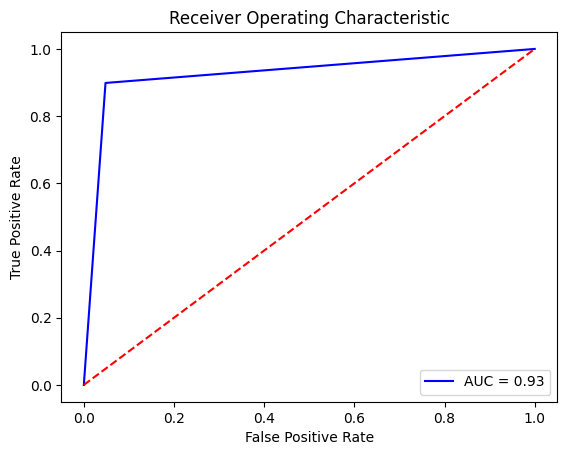

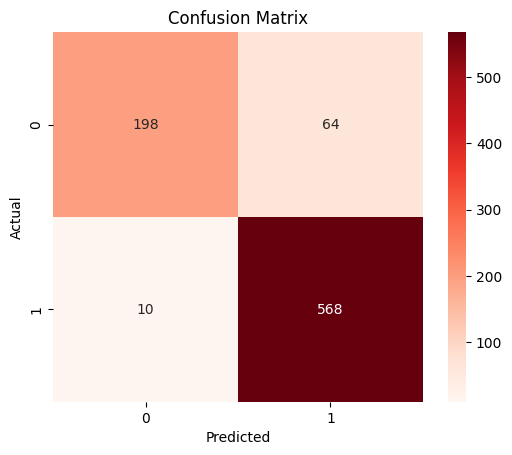

In [ ]:
# Using the best model for ROC graph
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

best_KNN = KNeighborsClassifier(n_neighbors=77, weights='distance', n_jobs=-1)
best_KNN.fit(x_train, y_train.values.ravel())
Y_pred = best_KNN.predict(x_test)

# plotting the ROC curves
fpr, tpr, threshold = metrics.roc_curve(Y_pred, y_test)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# A confusion matrix is created to visualize the performance of the model.
cm = confusion_matrix(y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt=".0f", square=True, cmap='Reds')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

#XGBOOST

In [ ]:
target = 'Default'
final_vars3 = [ 'Delay', 'Age', 'worked_day',  'Saving', 'Income',
              'Score', 'SBS_score','Debt_imp', 'FS_exp_imp', 'Credit_line_imp',
              'FLG_LIMA', 'Education_st', 'Housing_st', 'GeoZone_cat_st']

In [ ]:
nfolds=10
kf = KFold(n_splits=nfolds, random_state=42, shuffle=True)
for i, (train_index, validation_index) in enumerate(kf.split(data)):
    data.loc[validation_index, 'kfold'] = i


In [ ]:
paramGrid = {'learning_rate': [0.01,0.03,0.05,0.1],
         'colsample_bytree': [0.1,0.2,0.3],
         'max_depth': [8,10,15],
         'subsample': [0.1,0.2,0.3],
         'n_estimators':[3000],
         'reg_alpha': [0.15,0.3],
         'reg_lambda': [0.15,0.2,0.3],
         'booster':['gbtree'],
         'objective':['binary:logistic'],
         'eval_metric':['auc'],
         'n_jobs':[36],
         'use_label_encoder':[False],
         'random_state':[0]}

paramName, paramVal = zip(*paramGrid.items())
result = [dict(zip(paramName, p)) for p in product(*paramVal)]
len(result)



648

In [ ]:
def cv_watchlist_xgboost(param, data):
    nfolds=10
    results_cv = pd.DataFrame(columns=['param','run','precision','recall','f1_score','accuracy'])
    i=1
    for cv_sample in range(0, nfolds-2):
        train_70 = data.loc[data['kfold'].isin([cv_sample,cv_sample+1])][variables+[target]]
        x_train = train_70[variables]
        y_train = train_70[target]

        watch_10 = data.loc[data['kfold'].isin([cv_sample+2])][variables+[target]]
        x_watch = watch_10[variables]
        y_watch = watch_10[target]

        test_20 = data.loc[~data['kfold'].isin([cv_sample,cv_sample+1,cv_sample+2])][variables+[target]]
        x_test = test_20[variables]
        y_test = test_20[target]

        xgb_model =   xgb.XGBClassifier(
                                      booster='gbtree',
                                      objective='binary:logistic',
                                      colsample_bytree=param['colsample_bytree'],
                                      subsample=param['subsample'],
                                      learning_rate=param['learning_rate'],
                                      max_depth=param['max_depth'],
                                      n_estimators=param['n_estimators'],
                                      n_jobs=36,random_state=0,
                                      eval_metrics ='logloss',
                                      reg_alpha=param['reg_alpha'],
                                      reg_lambda=param['reg_lambda'],
                                      use_label_encoder = False,
                                      eval_set=[(X_watch, y_watch)]
                                      )

        xgb_model_f.fit(x_train, y_train, eval_set=[(x_watch, y_watch)],early_stopping_rounds=100,verbose = 0,eval_metric ='logloss')
        y_pred = xgb_model_f.predict(x_test)

        report = classification_report(y_test, y_pred).split()
        results_cv = results_cv.append({'param':param,'run':i,'precision':report[10],'recall':report[11],'f1_score':report[12],'accuracy':report[15]},ignore_index=True)

    return results_cv




In [ ]:
#TUNNING
import time
iterResults = pd.DataFrame(columns=['param','run','precision','recall','f1_score','accuracy'])
start_time = time.time()
LOG_EVERY_N=100
i=0
for param in result:
    i+=1
    if (i % LOG_EVERY_N) == 0: print(i)
    iterResults = iterResults.append(cv_watchlist_xgboost(param, data))

iterResults.to_csv('resultado_tunning_xgboost.csv')
elapsed = (time.time() - start_time)/(60*60)
print("CPU Master Table elapsed : %f hours" %(elapsed))
#takes aprox 7 hours


In [ ]:
model.cv_results_

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(data[final_vars3],data[target],test_size=0.2,random_state=123)

X_train2, X_watch, y_train2, y_watch  = train_test_split(X_train,y_train,test_size=0.2,random_state=123)



In [ ]:
#BEST MODEL
param = {'learning_rate': 0.1,
         'colsample_bytree': 0.3,
         'max_depth': 12,
         'subsample': 0.3,
         'n_estimators': 3000,
         'reg_alpha': 0.15,
         'reg_lambda': 0.15,
         'booster': 'gbtree',
         'objective': 'binary:logistic',
         'eval_metric': 'auc',
         'n_jobs': 36,
         'use_label_encoder': False,
         'random_state': 0}

xgb_model =   xgb.XGBClassifier(base_score=0.5,
                              booster='gbtree',
                              objective='binary:logistic',
                              colsample_bytree=param['colsample_bytree'],
                              subsample=param['subsample'],
                              learning_rate=param['learning_rate'],
                              max_depth=param['max_depth'],
                              n_estimators=param['n_estimators'],
                              n_jobs=36,random_state=0,
                              reg_alpha=param['reg_alpha'],
                              reg_lambda=param['reg_lambda'],
                              eval_set=[(X_watch, y_watch)]
                              )

xgb_model.fit(X_train2, y_train2, eval_set=[(X_watch, y_watch)],eval_metric='auc',early_stopping_rounds=100)




[03:52:29] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set" } are not used.

[0]	validation_0-auc:0.64288
[1]	validation_0-auc:0.66794
[2]	validation_0-auc:0.71725


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-auc:0.73378
[4]	validation_0-auc:0.74522
[5]	validation_0-auc:0.75213
[6]	validation_0-auc:0.76601
[7]	validation_0-auc:0.77313
[8]	validation_0-auc:0.77454
[9]	validation_0-auc:0.77700
[10]	validation_0-auc:0.77938
[11]	validation_0-auc:0.78870
[12]	validation_0-auc:0.79774
[13]	validation_0-auc:0.79922
[14]	validation_0-auc:0.81030
[15]	validation_0-auc:0.81331
[16]	validation_0-auc:0.81428
[17]	validation_0-auc:0.81613
[18]	validation_0-auc:0.81893
[19]	validation_0-auc:0.81749
[20]	validation_0-auc:0.81751
[21]	validation_0-auc:0.81785
[22]	validation_0-auc:0.82335
[23]	validation_0-auc:0.82733
[24]	validation_0-auc:0.82481
[25]	validation_0-auc:0.82728
[26]	validation_0-auc:0.82923
[27]	validation_0-auc:0.83047
[28]	validation_0-auc:0.83284
[29]	validation_0-auc:0.83405
[30]	validation_0-auc:0.83493
[31]	validation_0-auc:0.83551
[32]	validation_0-auc:0.83713
[33]	validation_0-auc:0.83823
[34]	validation_0-auc:0.84053
[35]	validation_0-auc:0.84440
[36]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              eval_set=[(      Delay  Age  worked_day  Saving   Income  Score  SBS_score  Debt_imp  \
3302      0   32        4325       8  2500.00    186          0    332.64   
3835      0   23        3595      12  1201.60    175          0   6962.45   
7338      0   38        6670      12  6500.00    216          0      0.00   
71...
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=3000, n_jobs=36,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.69      0.76       503
           1       0.88      0.95      0.91      1177

    accuracy                           0.87      1680
   macro avg       0.87      0.82      0.84      1680
weighted avg       0.87      0.87      0.87      1680



In [ ]:
fpr, tpr, threshold = metrics.roc_curve(y_pred, y_test)
roc_auc = metrics.auc(fpr, tpr)
print(2*roc_auc-1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



